In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from data_cleanup import *
from feature_selection import *
from model_ import *

from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as rmse
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LassoLarsCV
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = load_reduced_df()

In [3]:
corr_cols = ['bci_bci', 'ti_cpi', 'vdem_corr', 'vdem_execorr', 'vdem_jucorrdc', 'vdem_pubcorr', 'wbgi_cce']

In [4]:
df = drop_date_columns(df)

best_features_dict = {}
selected_features_dict = {}


for target_col in corr_cols:
    X_train, X_test, y_train, y_test = create_traintestsplit(df, target_col=target_col)

    best_features = pre_select(X_train, y_train)
    best_features = filter_corruption(best_features)
    best_features_dict[target_col] = set(best_features)
    
    selected_features_dict[target_col] = set(filter_highly_correleated(X_train, best_features))


In [5]:
best_features_union=list(set.union(*list(best_features_dict.values())))
best_features_intersection=list(set.intersection(*list(best_features_dict.values())))

best_features_intersection

['wbgi_vae', 'vdem_egaldem', 'wbgi_rle', 'wbgi_rqe', 'wbgi_gee', 'vdem_egal']

In [6]:
selected_features_union=list(set.union(*list(selected_features_dict.values())))
selected_features_intersection=list(set.intersection(*list(selected_features_dict.values())))

selected_features_intersection

['wbgi_rle', 'wbgi_rqe', 'wbgi_vae', 'vdem_egal']

In [7]:
def lasso_info_script(features):
    lasso_bf = dict()

    df_score = pd.DataFrame(columns=['r2', 'rmse'], index=corr_cols)
    for target in corr_cols:
        if isinstance(features, dict):
            lasso_bf[target] = apply_lassocv(df, target, list(features[target]), fprint=False)
        else:
            lasso_bf[target] = apply_lassocv(df, target, features, fprint=False)
        df_score.loc[target,] = [lasso_bf[target]['r2'] ,lasso_bf[target]['rmse']]
    
    print('scores')
    display(df_score)

    l_fi = [lasso_bf[target]['feat_importance'] for target in corr_cols]
    df_fi = pd.concat(l_fi)

    l_firk = [lasso_bf[target]['feat_importance_rank'] for target in corr_cols]
    df_firk = pd.concat(l_firk)

    print('feature importance')
    display(df_fi)
    df_fi.T.plot(kind='bar', figsize=(20,8))
    print()

    print('feature importance rank')
    display(df_firk)
    print()


scores


,r2,rmse
bci_bci,0.704616,60.045005
ti_cpi,0.477177,245.268571
vdem_corr,0.68682,0.025585
vdem_execorr,0.617259,0.031556
vdem_jucorrdc,0.452936,0.365164
vdem_pubcorr,0.690405,0.025262
wbgi_cce,0.871849,0.105543


feature importance


,ihme_lifexp_0104m,ihme_hle_0104m,wbgi_pvs,ihme_lifexp_0104t,vdem_libdem,vdem_edcomp_thick,vdem_egaldem,fh_status,wbgi_rqe,ihme_hle_0104f,...,vdem_delibdem,wbgi_vae,vdem_partipdem,wbgi_rle,wbgi_pvn,vdem_liberal,vdem_egal,fh_cl,wbgi_pve,fh_pr
bci_bci,0.051502,0.0,0.050149,0.0,0.0,0.0,0.0,0.045258,0.0,0.055901,...,0.0,0.0,0.0,0.371273,0.079676,0.0,0.0,0.054597,0.0,0.0
ti_cpi,0.034026,0.0,0.390525,0.0,0.0,0.023596,0.0,0.0,0.0,0.028669,...,0.036872,0.113279,0.007787,0.149702,0.126844,0.0,0.0,0.067503,0.021197,0.0
vdem_corr,0.0,0.0,0.040714,0.010121,0.328493,0.0,0.0,0.0,0.045575,0.0,...,0.006348,0.0,0.086729,0.104163,0.044057,0.0,0.046216,0.038645,0.019063,0.00397
vdem_execorr,0.0,0.0,0.007017,0.0,0.185841,0.005889,0.0,0.0,0.009445,0.0,...,0.0,0.0,0.0,0.212967,0.0,0.175471,0.112309,0.088424,0.013649,0.0
vdem_jucorrdc,0.0,0.000896,0.022233,0.0,0.252142,0.077986,0.0,0.006329,0.03165,0.0,...,0.051932,0.068434,0.029342,0.069457,0.023187,0.005771,0.013267,0.039625,0.002492,0.017293
vdem_pubcorr,0.024109,0.0,0.033673,0.0,0.211304,0.001535,0.0,0.0,0.019661,0.0,...,0.0,0.048066,0.0,0.123786,0.053176,0.063169,0.098313,0.033867,0.036055,0.0
wbgi_cce,0.039344,0.0,0.044632,0.0,0.015393,0.0,0.012719,0.01502,0.022146,0.060505,...,0.0,0.023976,0.0,0.385428,0.080631,0.0,0.0,0.0,0.010109,0.0



feature importance rank


,ihme_lifexp_0104m,ihme_hle_0104m,wbgi_pvs,ihme_lifexp_0104t,vdem_libdem,vdem_edcomp_thick,vdem_egaldem,fh_status,wbgi_rqe,ihme_hle_0104f,...,vdem_delibdem,wbgi_vae,vdem_partipdem,wbgi_rle,wbgi_pvn,vdem_liberal,vdem_egal,fh_cl,wbgi_pve,fh_pr
bci_bci,7,<NA>,8,<NA>,<NA>,<NA>,<NA>,9,<NA>,4,...,<NA>,<NA>,<NA>,1,3,<NA>,<NA>,5,<NA>,<NA>
ti_cpi,7,<NA>,1,<NA>,<NA>,9,<NA>,<NA>,<NA>,8,...,6,4,11,2,3,<NA>,<NA>,5,10,<NA>
vdem_corr,<NA>,<NA>,9,12,1,<NA>,<NA>,<NA>,7,<NA>,...,13,<NA>,4,3,8,<NA>,6,10,11,15
vdem_execorr,<NA>,<NA>,9,<NA>,3,10,<NA>,<NA>,8,<NA>,...,<NA>,<NA>,<NA>,1,<NA>,4,5,6,7,<NA>
vdem_jucorrdc,<NA>,20,12,<NA>,1,3,<NA>,17,9,<NA>,...,7,6,10,5,11,18,16,8,19,14
vdem_pubcorr,11,<NA>,10,<NA>,2,14,<NA>,<NA>,12,<NA>,...,<NA>,7,<NA>,3,6,5,4,9,8,<NA>
wbgi_cce,6,<NA>,5,<NA>,9,<NA>,11,10,8,4,...,<NA>,7,<NA>,1,3,<NA>,<NA>,<NA>,12,<NA>


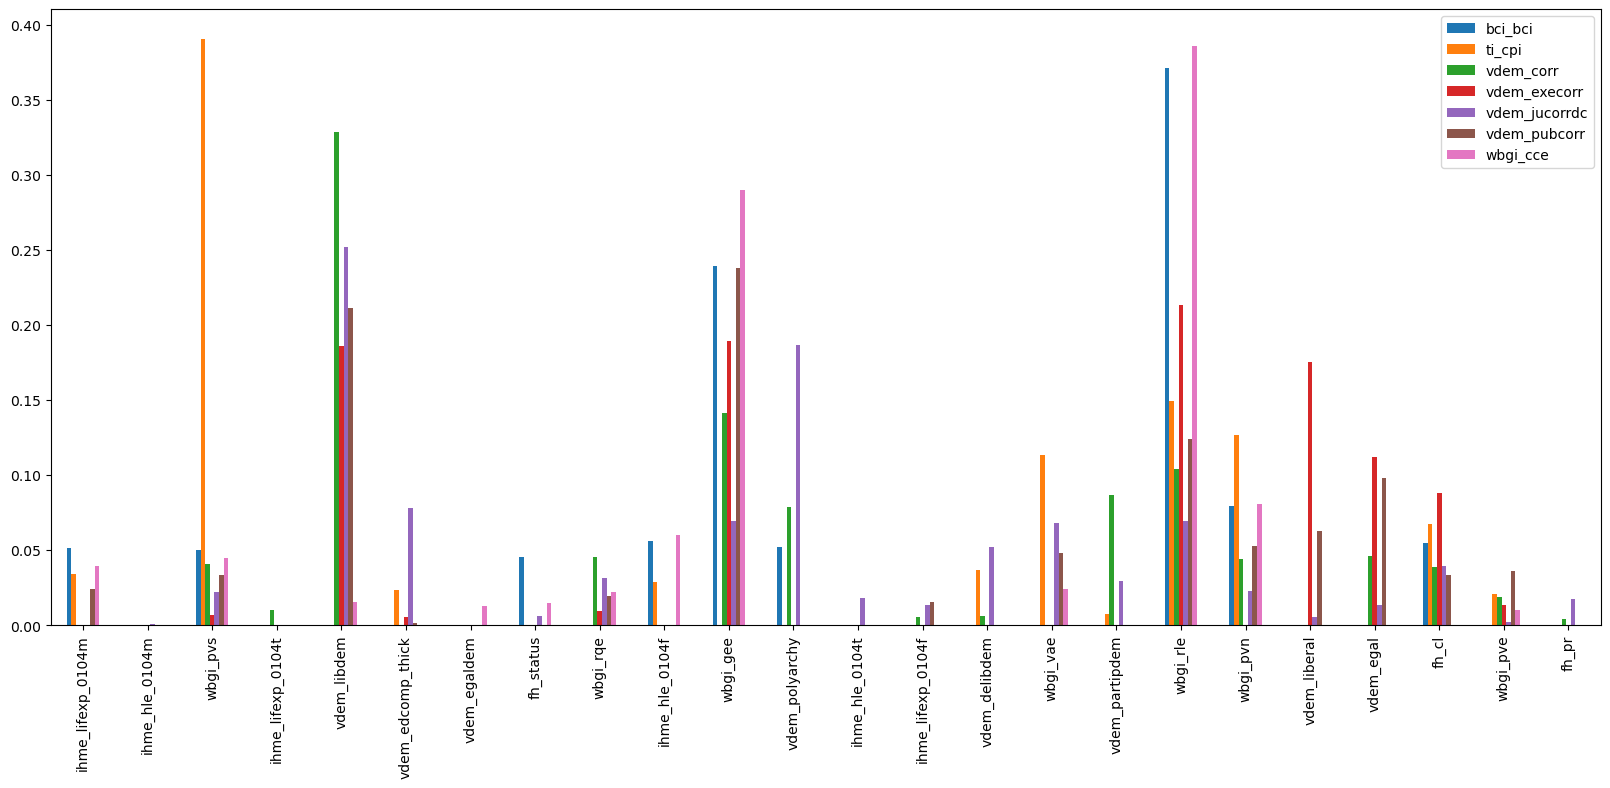

In [8]:
lasso_info_script(best_features_union)

scores


,r2,rmse
bci_bci,0.640983,72.980141
ti_cpi,0.093176,425.41252
vdem_corr,0.652719,0.028371
vdem_execorr,0.602052,0.03281
vdem_jucorrdc,0.332083,0.445834
vdem_pubcorr,0.684921,0.025709
wbgi_cce,0.848413,0.124845


feature importance


,wbgi_rle,wbgi_rqe,wbgi_vae,vdem_egal
bci_bci,0.772748,0.0,0.212659,0.014593
ti_cpi,1.0,0.0,0.0,0.0
vdem_corr,0.587714,0.100174,0.125267,0.186845
vdem_execorr,0.505472,0.0,0.22756,0.266968
vdem_jucorrdc,0.771018,0.0,0.205158,0.023824
vdem_pubcorr,0.533387,0.0,0.199039,0.267574
wbgi_cce,0.958023,0.0,0.03708,0.004898



feature importance rank


,wbgi_rle,wbgi_rqe,wbgi_vae,vdem_egal
bci_bci,1,<NA>,2,3
ti_cpi,1,<NA>,<NA>,<NA>
vdem_corr,1,4,3,2
vdem_execorr,1,<NA>,3,2
vdem_jucorrdc,1,<NA>,2,3
vdem_pubcorr,1,<NA>,3,2
wbgi_cce,1,<NA>,2,3


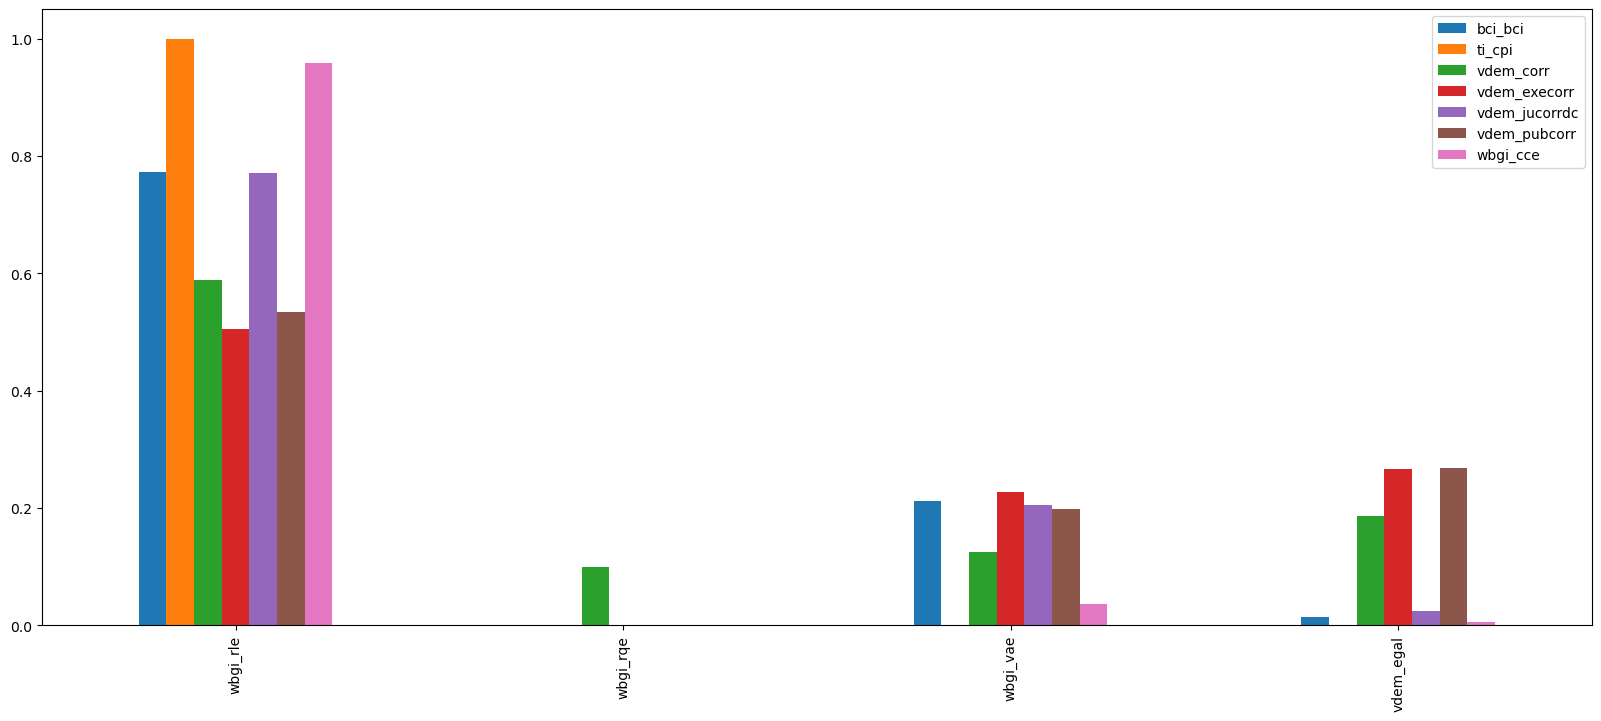

In [9]:
lasso_info_script(selected_features_intersection)

scores


,r2,rmse
bci_bci,0.642825,72.605747
ti_cpi,0.462074,252.353988
vdem_corr,0.661511,0.027653
vdem_execorr,0.611724,0.032012
vdem_jucorrdc,0.33616,0.443112
vdem_pubcorr,0.679818,0.026126
wbgi_cce,0.85055,0.123085


feature importance


,ihme_lifexp_0104m,wbgi_vae,wbgi_pve,wbgi_rle,wbgi_rqe,ihme_lifexp_0104t,vdem_liberal,vdem_egal,vdem_egaldem,wbgi_pvs,wbgi_pvn,vdem_polyarchy
bci_bci,0.010905,0.146913,0.0,0.774644,0.0,0.0,0.067538,0.0,NaN,NaN,NaN,NaN
ti_cpi,0.065997,0.076588,NaN,0.180057,0.011831,0.054329,NaN,0.010874,0.057728,0.399457,0.143138,NaN
vdem_corr,NaN,0.056432,0.030343,0.53676,0.090031,NaN,NaN,0.135499,NaN,NaN,NaN,0.150933
vdem_execorr,NaN,0.0,NaN,0.55643,0.0,NaN,NaN,0.225721,NaN,NaN,NaN,0.217849
vdem_jucorrdc,NaN,0.11089,0.004527,0.793917,0.0,NaN,NaN,0.010954,NaN,NaN,NaN,0.079712
vdem_pubcorr,NaN,0.110571,0.030042,0.454917,0.0,NaN,NaN,0.162804,NaN,NaN,NaN,0.241667
wbgi_cce,NaN,0.036905,0.019647,0.941886,0.0,NaN,NaN,0.001563,NaN,NaN,NaN,0.0



feature importance rank


,ihme_lifexp_0104m,wbgi_vae,wbgi_pve,wbgi_rle,wbgi_rqe,ihme_lifexp_0104t,vdem_liberal,vdem_egal,vdem_egaldem,wbgi_pvs,wbgi_pvn,vdem_polyarchy
bci_bci,4,2,<NA>,1,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>
ti_cpi,5,4,<NA>,2,8,7,<NA>,9,6,1,3,<NA>
vdem_corr,<NA>,5,6,1,4,<NA>,<NA>,3,<NA>,<NA>,<NA>,2
vdem_execorr,<NA>,<NA>,<NA>,1,<NA>,<NA>,<NA>,2,<NA>,<NA>,<NA>,3
vdem_jucorrdc,<NA>,2,5,1,<NA>,<NA>,<NA>,4,<NA>,<NA>,<NA>,3
vdem_pubcorr,<NA>,4,5,1,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,2
wbgi_cce,<NA>,2,3,1,<NA>,<NA>,<NA>,4,<NA>,<NA>,<NA>,<NA>


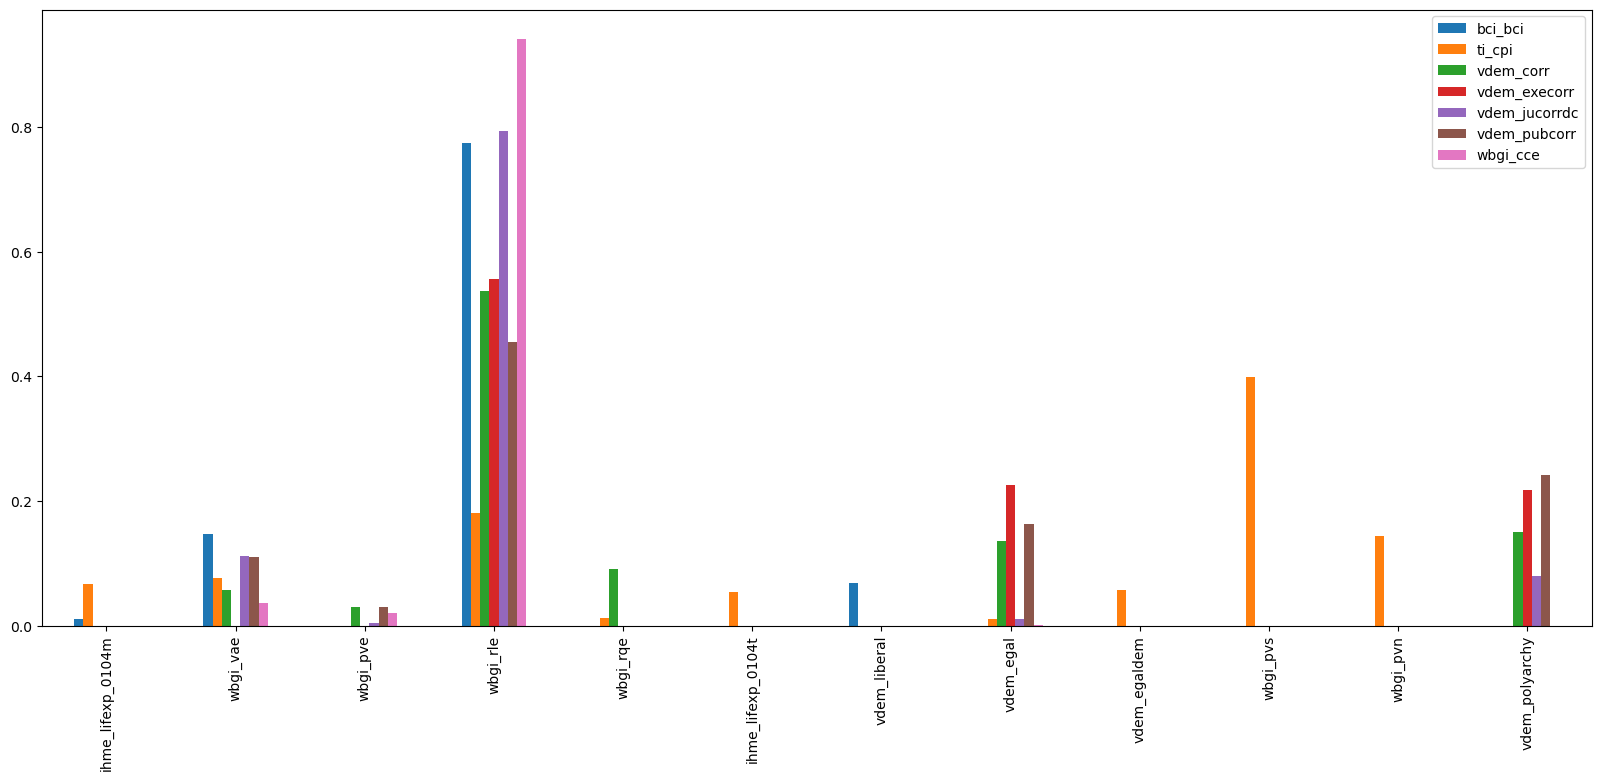

In [10]:
lasso_info_script(selected_features_dict)

In [17]:
def rf_info_script(features):
    rf_bf = dict()

    df_score = pd.DataFrame(columns=['r2', 'rmse'], index=corr_cols)
    for target in corr_cols:
        if isinstance(features, dict):
            rf_bf[target] = apply_rf(df, target, list(features[target]), fprint=False)
        else:
            rf_bf[target] = apply_rf(df, target, features, fprint=False)
        df_score.loc[target,] = [rf_bf[target]['r2'] ,rf_bf[target]['rmse']]
    
    print('scores')
    display(df_score)

    l_fi = [rf_bf[target]['feat_importance'] for target in corr_cols]
    df_fi = pd.concat(l_fi)

    l_firk = [rf_bf[target]['feat_importance_rank'] for target in corr_cols]
    df_firk = pd.concat(l_firk)

    print('feature importance')
    display(df_fi)

    df_fi.T.plot(kind='bar', figsize=(20,8))
    print()

    print('feature importance rank')
    display(df_firk)
    print()



scores


,r2,rmse
bci_bci,0.677673,65.52193
ti_cpi,0.940358,27.979295
vdem_corr,0.66134,0.027666
vdem_execorr,0.633335,0.030231
vdem_jucorrdc,0.339384,0.44096
vdem_pubcorr,0.645923,0.028892
wbgi_cce,0.867003,0.109535


feature importance


,ihme_lifexp_0104m,ihme_hle_0104m,wbgi_pvs,ihme_lifexp_0104t,vdem_libdem,vdem_edcomp_thick,vdem_egaldem,fh_status,wbgi_rqe,ihme_hle_0104f,...,vdem_delibdem,wbgi_vae,vdem_partipdem,wbgi_rle,wbgi_pvn,vdem_liberal,vdem_egal,fh_cl,wbgi_pve,fh_pr
bci_bci,0.002658,0.003123,0.002345,0.001931,0.018967,0.005983,0.006333,0.001214,0.006866,0.005324,...,0.009395,0.007535,0.010117,0.489518,0.003785,0.010652,0.010566,0.002045,0.007014,0.001441
ti_cpi,0.001966,0.001042,0.664946,0.000735,0.001131,0.002039,0.001476,0.000244,0.009444,0.000792,...,0.001701,0.003439,0.001898,0.267579,0.017616,0.001352,0.004562,0.000605,0.006439,0.000158
vdem_corr,0.005406,0.004168,0.001865,0.002095,0.062151,0.010435,0.007432,0.000307,0.006575,0.005417,...,0.005353,0.017774,0.006741,0.433007,0.001479,0.104534,0.268651,0.000883,0.014538,0.001325
vdem_execorr,0.005938,0.004123,0.003524,0.002297,0.092193,0.013893,0.015022,0.000501,0.009706,0.00414,...,0.016126,0.013457,0.010151,0.097319,0.00204,0.166927,0.468034,0.002563,0.013097,0.002222
vdem_jucorrdc,0.005358,0.007301,0.002213,0.003709,0.011728,0.012803,0.006848,0.000301,0.007379,0.00524,...,0.007215,0.042374,0.009158,0.68411,0.002117,0.113601,0.022161,0.001818,0.011569,0.001358
vdem_pubcorr,0.002493,0.003305,0.002819,0.002208,0.112334,0.008033,0.167752,0.000405,0.006817,0.005438,...,0.004733,0.004254,0.006384,0.263036,0.001449,0.057609,0.168785,0.0014,0.01526,0.001349
wbgi_cce,0.001655,0.001222,0.002121,0.000962,0.00241,0.00246,0.002543,0.000143,0.005062,0.00206,...,0.001616,0.005829,0.002223,0.874701,0.001081,0.002846,0.004517,0.000829,0.00652,0.000514



feature importance rank


,ihme_lifexp_0104m,ihme_hle_0104m,wbgi_pvs,ihme_lifexp_0104t,vdem_libdem,vdem_edcomp_thick,vdem_egaldem,fh_status,wbgi_rqe,ihme_hle_0104f,...,vdem_delibdem,wbgi_vae,vdem_partipdem,wbgi_rle,wbgi_pvn,vdem_liberal,vdem_egal,fh_cl,wbgi_pve,fh_pr
bci_bci,18,17,19,22,4,13,12,24,11,14,...,8,9,7,1,15,5,6,21,10,23
ti_cpi,10,17,1,21,16,9,13,23,4,20,...,12,8,11,2,3,15,7,22,6,24
vdem_corr,14,16,20,19,4,8,10,24,12,13,...,15,6,11,1,21,3,2,23,7,22
vdem_execorr,14,16,17,21,4,8,7,24,12,15,...,6,9,11,3,23,2,1,20,10,22
vdem_jucorrdc,15,11,20,19,7,6,13,24,10,16,...,12,3,9,1,21,2,5,22,8,23
vdem_pubcorr,18,16,17,19,5,8,3,24,10,12,...,13,14,11,1,21,6,2,22,7,23
wbgi_cce,15,18,12,20,10,9,8,24,5,13,...,16,4,11,1,19,7,6,22,3,23


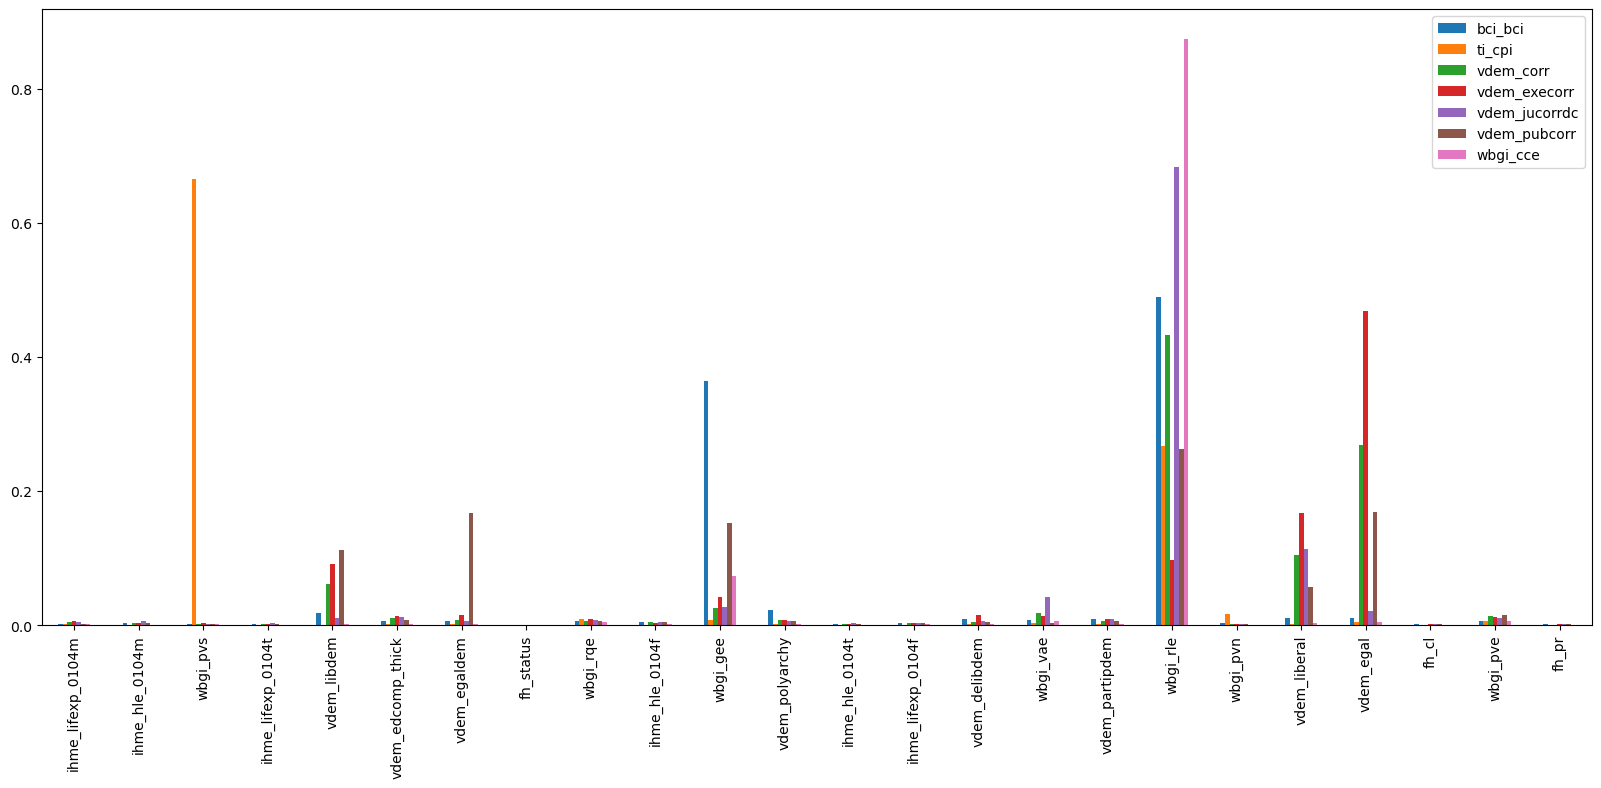

In [19]:
rf_info_script(best_features_union)

scores


,r2,rmse
bci_bci,0.631843,74.837992
ti_cpi,-0.072689,503.22357
vdem_corr,0.652508,0.028388
vdem_execorr,0.576073,0.034952
vdem_jucorrdc,0.287492,0.475598
vdem_pubcorr,0.617862,0.031181
wbgi_cce,0.838495,0.133013


feature importance


,wbgi_rle,wbgi_rqe,wbgi_vae,vdem_egal
bci_bci,0.865338,0.026236,0.067064,0.041362
ti_cpi,0.326125,0.247033,0.216939,0.209902
vdem_corr,0.529585,0.02996,0.109912,0.330543
vdem_execorr,0.197474,0.052456,0.097203,0.652867
vdem_jucorrdc,0.772393,0.0438,0.113445,0.070361
vdem_pubcorr,0.516599,0.035741,0.12351,0.32415
wbgi_cce,0.948866,0.014651,0.01994,0.016544



feature importance rank


,wbgi_rle,wbgi_rqe,wbgi_vae,vdem_egal
bci_bci,1,4,2,3
ti_cpi,1,2,3,4
vdem_corr,1,4,3,2
vdem_execorr,2,4,3,1
vdem_jucorrdc,1,4,2,3
vdem_pubcorr,1,4,3,2
wbgi_cce,1,4,2,3


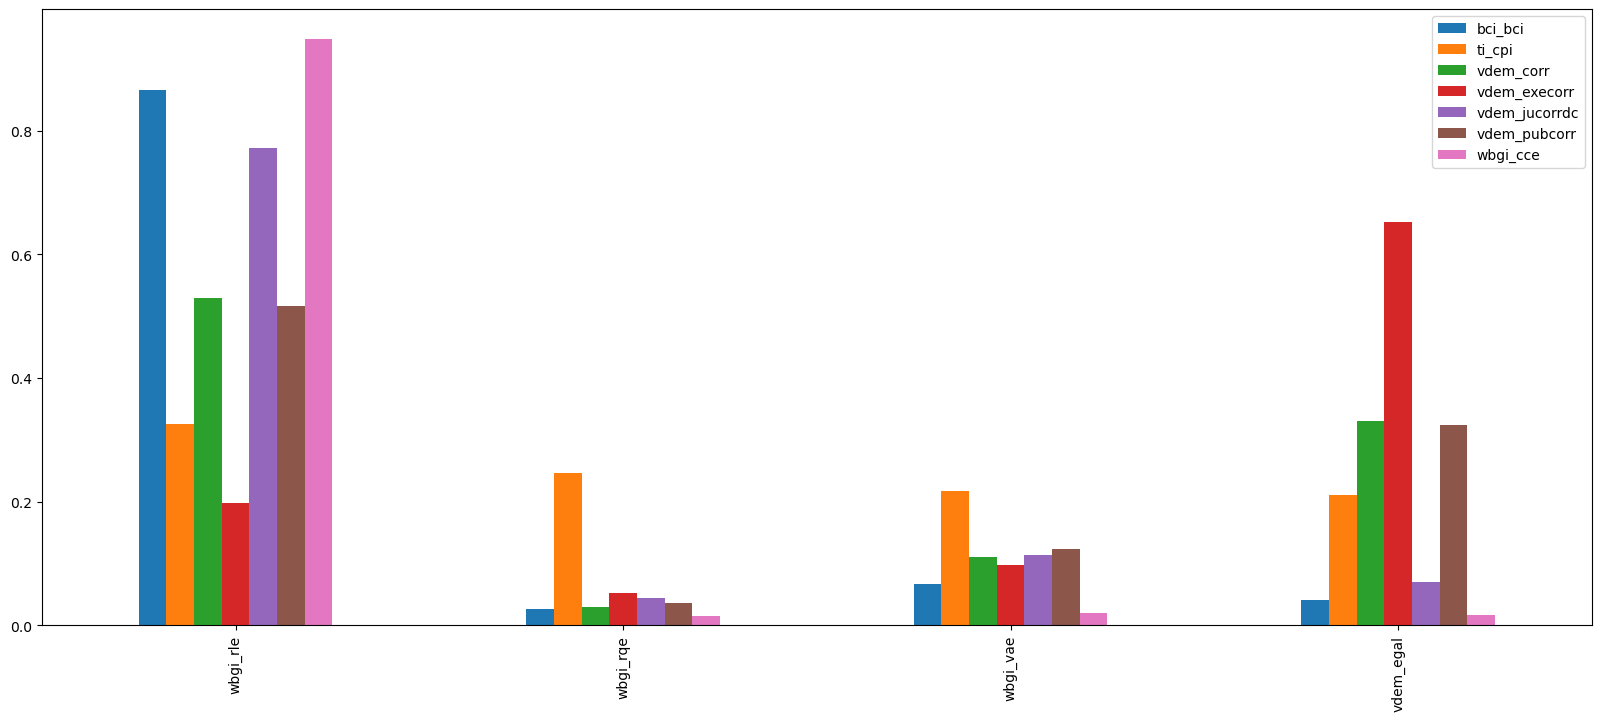

In [20]:
rf_info_script(selected_features_intersection)

scores


,r2,rmse
bci_bci,0.635273,74.140812
ti_cpi,0.934896,30.541699
vdem_corr,0.71544,0.023247
vdem_execorr,0.595083,0.033384
vdem_jucorrdc,0.333832,0.444666
vdem_pubcorr,0.638029,0.029536
wbgi_cce,0.855225,0.119235


feature importance


,ihme_lifexp_0104m,wbgi_vae,wbgi_pve,wbgi_rle,wbgi_rqe,ihme_lifexp_0104t,vdem_liberal,vdem_egal,vdem_egaldem,wbgi_pvs,wbgi_pvn,vdem_polyarchy
bci_bci,0.009617,0.028975,0.01319,0.85251,0.014195,0.009702,0.04818,0.023631,NaN,NaN,NaN,NaN
ti_cpi,0.003021,0.005606,NaN,0.27381,0.012157,0.002254,NaN,0.00972,0.003536,0.669388,0.020509,NaN
vdem_corr,NaN,0.080751,0.024152,0.513875,0.01849,NaN,NaN,0.311659,NaN,NaN,NaN,0.051074
vdem_execorr,NaN,0.067328,NaN,0.182407,0.039707,NaN,NaN,0.630178,NaN,NaN,NaN,0.08038
vdem_jucorrdc,NaN,0.09162,0.023298,0.757724,0.032159,NaN,NaN,0.05249,NaN,NaN,NaN,0.042709
vdem_pubcorr,NaN,0.070303,0.015638,0.500161,0.021904,NaN,NaN,0.283315,NaN,NaN,NaN,0.108679
wbgi_cce,NaN,0.013187,0.010098,0.944404,0.011001,NaN,NaN,0.01024,NaN,NaN,NaN,0.01107



feature importance rank


,ihme_lifexp_0104m,wbgi_vae,wbgi_pve,wbgi_rle,wbgi_rqe,ihme_lifexp_0104t,vdem_liberal,vdem_egal,vdem_egaldem,wbgi_pvs,wbgi_pvn,vdem_polyarchy
bci_bci,8,3,6,1,5,7,2,4,<NA>,<NA>,<NA>,<NA>
ti_cpi,8,6,<NA>,2,4,9,<NA>,5,7,1,3,<NA>
vdem_corr,<NA>,3,5,1,6,<NA>,<NA>,2,<NA>,<NA>,<NA>,4
vdem_execorr,<NA>,4,<NA>,2,5,<NA>,<NA>,1,<NA>,<NA>,<NA>,3
vdem_jucorrdc,<NA>,2,6,1,5,<NA>,<NA>,3,<NA>,<NA>,<NA>,4
vdem_pubcorr,<NA>,4,6,1,5,<NA>,<NA>,2,<NA>,<NA>,<NA>,3
wbgi_cce,<NA>,2,6,1,4,<NA>,<NA>,5,<NA>,<NA>,<NA>,3


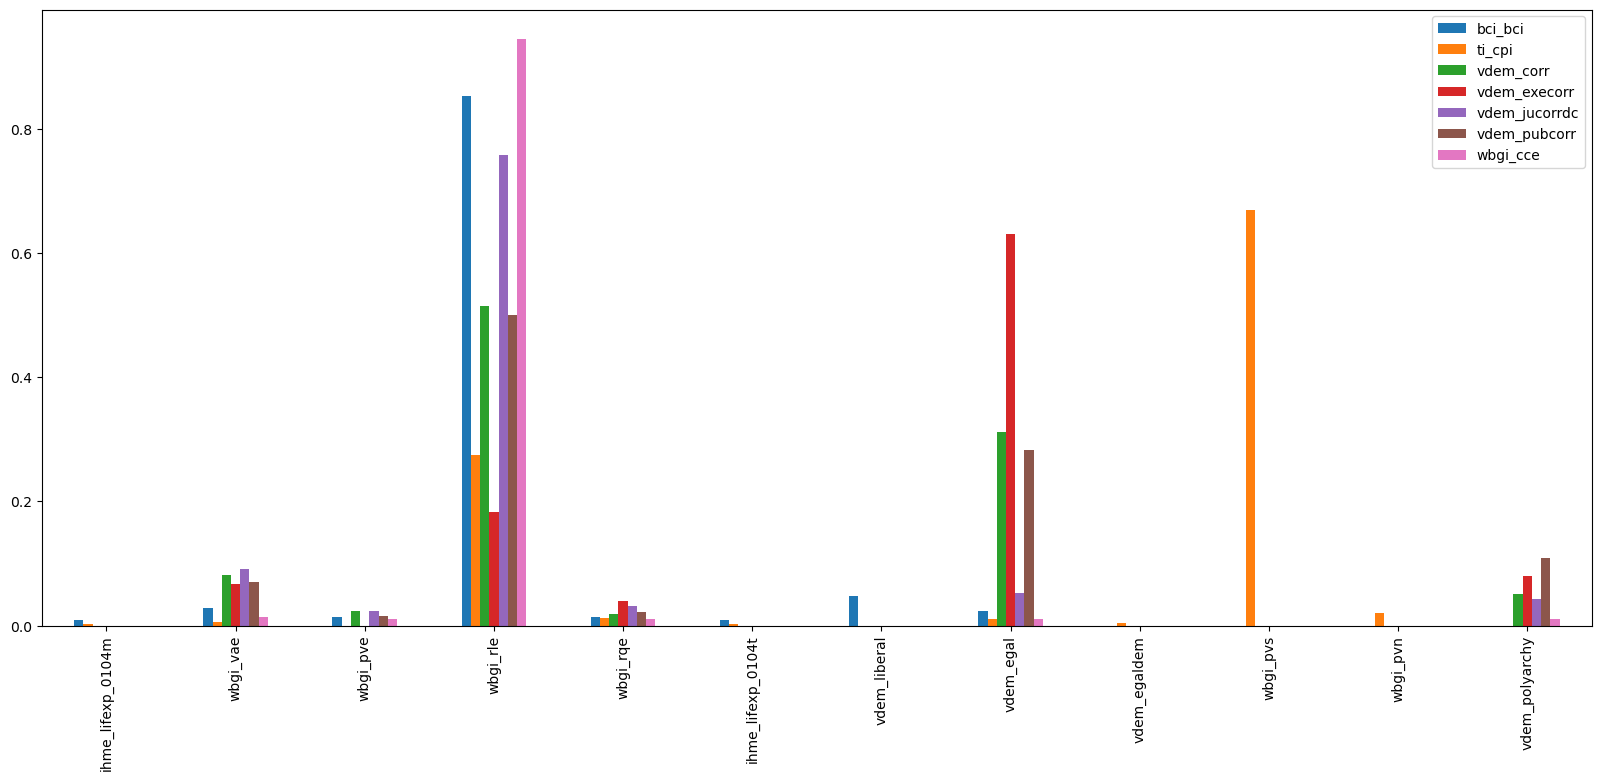

In [21]:
rf_info_script(selected_features_dict)

In [23]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

target="wbgi_cce"
X_train, X_test, y_train, y_test = create_traintestsplit(df, target_col=target)

param_grid = {
    "randomforestregressor__max_depth": [2, 3, 5, 10, None],
    "randomforestregressor__min_samples_split": [2, 5, 10],
    "randomforestregressor__max_features": ["log2", None]
    }

rf = RandomForestRegressor(random_state=45678)
model = make_pipeline(StandardScaler(),
    RandomForestRegressor(
        random_state=45678
    )
)
reg = GridSearchCV(model, param_grid, scoring="r2", refit=True)
reg.fit(X_train[selected_features_dict[target]], y_train)



['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_randomforestregressor__max_depth',
 'param_randomforestregressor__max_features',
 'param_randomforestregressor__min_samples_split',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [27]:
reg.best_score_

0.9380793929523523

In [26]:
best_rf = reg.best_estimator_
best_rf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_features=None, random_state=45678))])

In [ ]:
y_pred = model.predict(X_test[features])